In [1]:
# This file is part of pydidas.
#
# Copyright 2023 - 2024, Helmholtz-Zentrum Hereon
# SPDX-License-Identifier: GPL-3.0-only
#
# pydidas is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License version 3 as
# published by the Free Software Foundation.
#
# Pydidas is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Pydidas. If not, see <http://www.gnu.org/licenses/>.

"""
The dataset module includes the Dataset subclasses of numpy.ndarray with additional
embedded metadata.
"""

__author__ = "Gudrun Lotze"
__copyright__ = "Copyright 2024, Helmholtz-Zentrum Hereon"
__license__ = "GPL-3.0-only"
__maintainer__ = "Gudrun Lotze"
__status__ = "Development"

In [2]:
import os
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from pydidas.core import Dataset
from pydidas.data_io import import_data
%matplotlib inline


import importlib
import sys

fname = '/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins/stress_strain.py'
spec = importlib.util.spec_from_file_location('stress_strain', fname)
stress_strain = importlib.util.module_from_spec(spec)
spec.loader.exec_module(stress_strain)

# Check if the module object is created
if hasattr(stress_strain, '__file__'):
    print("Module was successfully loaded.")

# Inspect module attributes
print("Module attributes:", dir(stress_strain))

#We need to append the path to the sys.path to import the module
sys.path.append('/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins')

from  stress_strain import extract_d_spacing, chi_pos_verification, extract_d_spacing, ds_slicing, combine_sort_d_spacing_pos_neg, group_d_spacing_by_chi, idx_s2c_grouping




Module was successfully loaded.
Module attributes: ['Dataset', '__author__', '__builtins__', '__cached__', '__copyright__', '__doc__', '__file__', '__license__', '__loader__', '__maintainer__', '__name__', '__package__', '__spec__', '__status__', 'chi_pos_verification', 'combine_sort_d_spacing_pos_neg', 'connected_components', 'csr_matrix', 'ds_slicing', 'extract_d_spacing', 'group_d_spacing_by_chi', 'h5', 'idx_s2c_grouping', 'import_data', 'np', 'os']


UNSUPPORTED (log once): buildComputeProgram: cl2Metal failed


Auxiliary functions

  fig.show()

  fig.show()

  fig.show()



Chi
 [-180 -170 -160 -150 -140 -130 -120 -110 -100  -90  -80  -70  -60  -50
  -40  -30  -20  -10    0   10   20   30   40   50   60   70   80   90
  100  110  120  130  140  150  160  170  180]
Result array spatial shape
 (6, 5, 37, 5)
Axis labels
 {0: 'y', 1: 'x', 2: 'chi', 3: '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'}
Shape of dataset
 (6, 5, 37, 5)
Type ds
 <class 'pydidas.core.dataset.Dataset'>
Content of ds1 before noise addition
 [25.28007189 25.30466048 25.3132     25.30466048 25.28007189 25.2424
 25.19618858 25.14701142 25.1008     25.06312811 25.03853952 25.03
 25.03853952 25.06312811 25.1008     25.14701142 25.19618858 25.2424
 25.28007189 25.30466048 25.3132     25.30466048 25.28007189 25.2424
 25.19618858 25.14701142 25.1008     25.06312811 25.03853952 25.03
 25.03853952 25.06312811 25.1008     25.14701142 25.19618858 25.2424
 25.28007189]
chi_key, pos_key, pos_idx:
0 1 0
s2c_pos [7.49879891e-33 3.01536896e-02 1.16977778e-01 2.50000000

  fig.show()



Block 1 total time: 0.916522666993842 seconds
Block 1 average time per run: 1.833045333987684e-05 seconds
Block 2 total time: 0.8210998750000726 seconds
Block 2 average time per run: 1.6421997500001453e-05 seconds
Dataset(
axis_labels: {
    0: 'sin2chi'},
axis_ranges: {
    0: array([7.49879891e-33, 3.01536896e-02, 1.16977778e-01, 2.50000000e-01,
              4.13175911e-01, 5.86824089e-01, 7.50000000e-01, 8.83022222e-01,
              9.69846310e-01, 1.00000000e+00])},
axis_units: {
    0: ''},
metadata: {},
data_unit: ,
data_label: d_spacing,
array([0.01863312, 0.06891353, 0.1278133 , 0.14653152, 0.16491079,
              nan, 0.16525827, 0.12031485, 0.05536027, 0.        ])
)


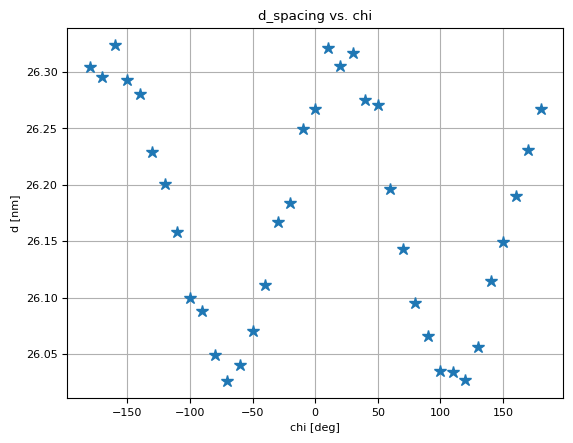

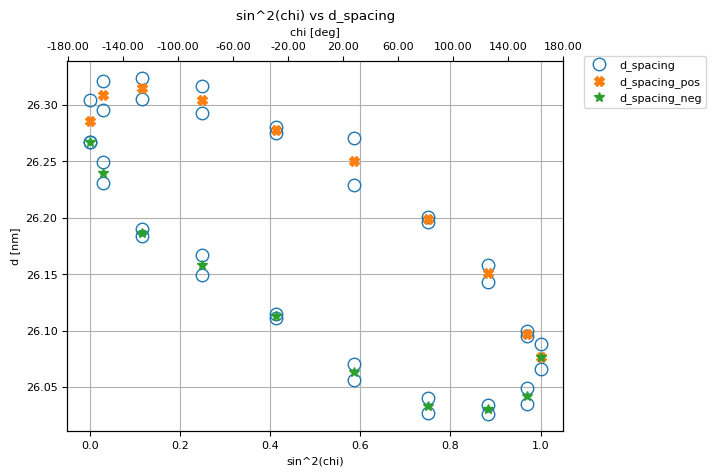

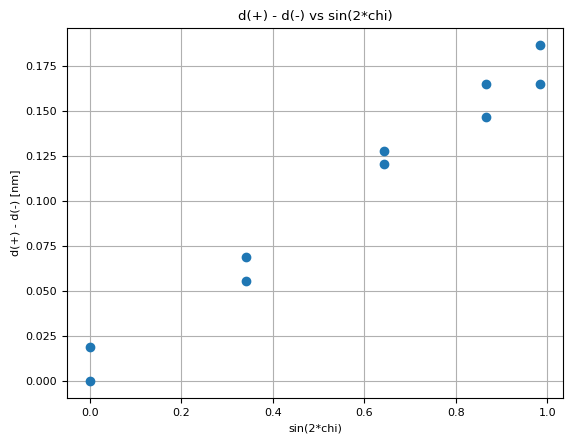

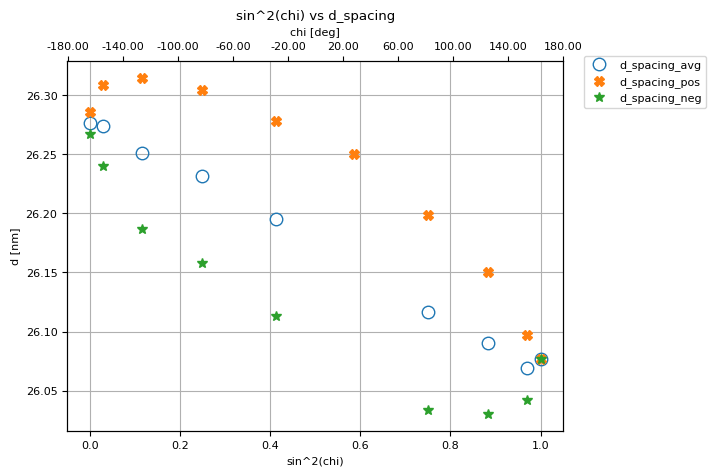

In [3]:
def chi_gen(chi_start, chi_stop, delta_chi):
    if chi_start >= chi_stop:
        raise ValueError('chi_start has to be smaller than chi_stop')
    return np.arange(chi_start, chi_stop, delta_chi)


def predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift):
    """ Calculate predefined metric based on name, applying spatial variation even if x is not provided. """
    # Handle spatial variation by introducing a default or random x if none is provided
    if x is None and spatial_var:
        x = np.random.uniform(0, 1)  #A random x between 0 and 5
    if metric_name == "position":
        return 0.2832*np.sin(np.deg2rad(chi+phase_shift))**2 + d0 + (0.01 * x if spatial_var else 0)
    if metric_name == "area":
        return np.random.uniform(6, 37, size=len(chi)) + 0.1 * y
    if metric_name == "FWHM":
        return np.random.uniform(0.35, 0.75, size=len(chi))
    if metric_name == "background at peak":
        return np.random.uniform(2.3, 5.3, size=len(chi))
    if metric_name == "total count intensity":
        return np.random.uniform(80, 800, size=len(chi))
    return np.random.uniform(1.5708, 3.141, size=len(chi))  # Fallback for unknown metrics

def generate_spatial_fit_res(y_range, x_range=None, chi_start=-175, chi_stop=180, delta_chi=10, fit_labels=None, spatial_var=True, phase_shift=0):
    '''
    chi [degree]
    phase_shift [degree]
    '''
    
    if fit_labels is None:
        fit_labels = '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(k.split(':')[0].strip()): k.split(':')[1].strip() for k in fit_labels.replace(', ', ';').split(';')}

    chi = chi_gen(chi_start, chi_stop, delta_chi)
    d0 = 25  # in nm

    # Determine the dimensions based on x_range
    if x_range is not None:
        result_array = np.empty((len(y_range), len(x_range), len(chi), len(fit_labels_dict)))
    else:
        result_array = np.empty((len(y_range), len(chi), len(fit_labels_dict)))
        x_range = [None]  # Simulate the absence of x values

    # Perform calculations for each y and x, and across all metrics
    for j, y in enumerate(y_range):
        for i, x in enumerate(x_range):
            fit_results = []
            for idx in sorted(fit_labels_dict.keys()):
                metric_name = fit_labels_dict[idx]
                result = predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift)
                fit_results.append(result)

            fit_results = np.array(fit_results)
            # Adjust how results are stored based on the presence of x_range
            # Debug print statements
            #print(f"fit_results.T.shape: {fit_results.T.shape}, j: {j}, i: {i}")
            #print('x_range:', x_range)
            if x is not None:
                result_array[j, i, :, :] = fit_results.T
            else:
                result_array[j, :, :] = fit_results.T  # Ensure dimensionality matches expected (len(chi), len(fit_labels_dict))

    return result_array

def adding_noise_d_spacing(d_spacing, scale=0.03, mean_value=1, seed=10):
    '''
    ds: Dataset, expecting in first column d-spacing values.
    Noise follows a Laplace distribution
    mean_value, scale: Mean_value and scale parameter of Laplace distribution
    Seed: radnom seed
    
    '''
    ds = d_spacing.copy()
    #Introducing seed and random noise for d_spacing
    # Define the scale parameter for the Laplace distribution
    # Generate Laplace noise centered around the mean value
    d_spacing_noise = np.random.default_rng(seed=seed).laplace(mean_value, scale, size=d_spacing.array.shape[0])
 
    d_spacing_with_noise = d_spacing.array[:,0] + d_spacing_noise
    #update array in ds
    ds.array[:,0] = d_spacing_with_noise
    return ds
  



def plot_d_spacing_vs_chi(ds, chi, positions):
    """
    Plots d_spacing vs chi for specified (x, y) positions in the result array using Matplotlib's OOP interface.

    Parameters:
        ds (Dataset): The 4D array containing measurement data.
        chi (numpy.ndarray): The array of chi values.
        positions (list of tuples): A list of (x_index, y_index) tuples specifying the positions to plot.
    """

    print('ds.shape:', ds.shape)
    
    fig, ax = plt.subplots()
    for (x_index, y_index) in positions:
        # Extract d_spacing for the specific position
        d_spacing = ds.array[x_index, y_index, :, 0]  # d_spacing is the first property in the last dimension
        
        # Plotting using the axes object
        ax.plot(chi, d_spacing, label=f'(x={x_index}, y={y_index})', marker='o', linestyle='--')
    
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('d_spacing')
    ax.set_title('d_spacing vs chi for various x,y')
    ax.grid(True)
    
    ax.legend()
    plt.show()
    
    

def main():
    
    import timeit
    
    #Creating of dummy data
    delta_chi =10
    chi_start= -180
    chi_stop= 181
    phase_shift = 70
    chi=chi_gen(chi_start, chi_stop, delta_chi)
    print('Chi\n', chi)
   
    #x, y in um
    y = np.arange(2, 8)
    x = np.arange(0, 5)

    #labels
    fit_labels= '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(item.split(":")[0].strip()): item.split(":")[1].strip() for item in fit_labels.split(";")}
    num_labels = len(fit_labels_dict)
    
    #creation of Pydidas Dataset
    axis_labels= ['y', 'x', 'chi', fit_labels]
    axis_ranges = {0: y, 1:x, 2: chi , 3: np.arange(num_labels)} 
    
   
    result_array_spatial = generate_spatial_fit_res(y, x, chi_start,chi_stop, delta_chi, fit_labels , spatial_var=True, phase_shift=phase_shift)
    #result_array = generate_spatial_fit_res(y, x, chi_start,chi_stop, delta_chi, fit_labels , spatial_var=False)
    print('Result array spatial shape\n', result_array_spatial.shape)
    

    ds = Dataset(result_array_spatial,  axis_labels=axis_labels, axis_ranges=axis_ranges)
    #ds_no_spatial = Dataset(result_array,  axis_labels=axis_labels, axis_ranges=axis_ranges)
    axis_labels = ds.axis_labels
    print('Axis labels\n', axis_labels)
    print('Shape of dataset\n', ds.shape)
    print('Type ds\n', type(ds))
    
    #visualisation
    #positions = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
    #plot_d_spacing_vs_chi(ds, chi, positions)
    #plot_d_spacing_vs_chi(ds_no_spatial, chi, positions)
      
    #choose random location in ds
    x_idx = 5
    y_idx = 3
    
    #plot_d_spacing_vs_chi(ds, chi, [(x_idx, y_idx)])
    
    
    # slice Dataset based on location
    ds1 = ds[x_idx, y_idx]
    print('Content of ds1 before noise addition\n', ds1.array[:,0])
          
    #Introducing seed and random noise for d_spacing
    ds1 = adding_noise_d_spacing(ds1, scale=0.01, mean_value=1, seed=10)
    #print('Shape of ds1 dataset\n', ds1.shape)
    #print('Content ds1 array after noise addition\n',  ds1.array[:,0])
    #print(ds1)
    
    
    #Introducing np.nan 
    #print('Content ds1 array',  ds1.array[:,0])
    #ds1.array[0:9:2,0] = np.nan
    #ds1.array[18:28:2,0] = np.nan
   
    fig, ax = plt.subplots()
    ax.plot(chi, ds1.array[:,0], linestyle='None', marker='*', label='d_spacing', markersize=9)
    ax.grid()
    ax.set_ylabel('d [nm]')
    ax.set_xlabel('chi [deg]')
    ax.set_title('d_spacing vs. chi')
    fig.show()
          
    chi_key, (pos_key, pos_idx) = chi_pos_verification(ds1)
    print('chi_key, pos_key, pos_idx:')
    print(chi_key, pos_key, pos_idx)
    
    chi, d_spacing = ds_slicing(ds1)    
        
    d_spacing_pos, d_spacing_neg=group_d_spacing_by_chi(d_spacing, chi)
    
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, d_spacing, linestyle='None', marker='o', label='d_spacing', markerfacecolor='None', markersize=9)
    ax.plot(d_spacing_pos.axis_ranges[0], d_spacing_pos.array, linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
    ax.plot(d_spacing_neg.axis_ranges[0], d_spacing_neg.array, linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
    ax.set_ylabel('d [nm]')
    ax.set_xlabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs d_spacing')
    interval = 4
    x_index = np.arange(0, len(chi), interval)
    ax2top=ax.twiny()
    ax2top.set_xlim(ax.get_xlim())
    formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
    ax2top.set_xticks(x_index)
    ax2top.set_xticklabels(formatted_labels)
    ax2top.set_xlabel('chi [deg]')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.03))
    ax.grid()
    fig.show()
    
      
    
    print('s2c_pos', d_spacing_pos.axis_ranges[0])
    print('d_spacing_pos', d_spacing_pos.array)
    print('s2c_neg', d_spacing_neg.axis_ranges[0])
    print('d_spacing_neg', d_spacing_neg.array)
    
    d_spacing_combined = combine_sort_d_spacing_pos_neg(d_spacing_pos, d_spacing_neg)
    #print('d_spacing_combined, shape', d_spacing_combined.shape)
    #print('d_spacing_combined', d_spacing_combined) 
    
    d_diff= np.diff(d_spacing_combined.array, axis=0).squeeze()
    x_diff = np.sin(2*np.arcsin(np.sqrt(d_spacing_combined.axis_ranges[1])))
    
    print('d_diff', d_diff)
    print('x_diff', x_diff)
    print(d_spacing_combined.axis_ranges[1])
    
    fig, ax = plt.subplots()
    ax.plot(x_diff, d_diff, linestyle='None', marker='o')
    ax.set_title('d(+) - d(-) vs sin(2*chi)')
    ax.set_xlabel('sin(2*chi)')
    ax.set_ylabel('d(+) - d(-) [nm]')
    ax.grid()
    fig.show()
    
    
    ds2 = ds1.copy()
    print(ds2)
    print(ds2+2)
    
    
    def normal_stress(d_spacing_combined):
        '''d_spacing_combined: Dataset, containing d_spacing values vs sin2chi values
           (d(+)+d(-))/2 vs sin2chi        
        '''
        
        print('In the function normal_stress')
        print('d_spacing_combined, shape', d_spacing_combined.shape)
        print('d_spacing_combined', d_spacing_combined)
        print(id(d_spacing_combined))
        print(100*'x')
        
        d_spacing_combined[0,5] = np.nan
        
        def block1():
            # This is the case where one part of the d_spacing pair is missing and not taken into account for the average
            #print(100*'+\\')
            d_spacing_avg_array = np.mean(d_spacing_combined.array, axis=0)
            d_spacing_avg = Dataset(d_spacing_avg_array, data_label='d_spacing_mean',  axis_labels={0: 'sin2chi'}, axis_ranges={0:d_spacing_combined.axis_ranges[1]})
            #print('d_spacing_avg\n', d_spacing_avg)
            #print(id(d_spacing_avg))
            #print(100*'-+')
            return d_spacing_avg

        def block2():
            d_spacing_avg1= np.mean(d_spacing_combined, axis=0)
            #print('d_spacing_avg1 after averaging,before update\n', d_spacing_avg1)
            d_spacing_avg1.axis_ranges={0: d_spacing_combined.axis_ranges[1]}
            d_spacing_avg1.axis_labels={0: 'sin2chi'}
            d_spacing_avg1.data_label='d_spacing_mean'
            #print(id(d_spacing_avg1))
            #print('d_spacing_avg1 after averaging, after update\n', d_spacing_avg1)
            return d_spacing_avg1
        
        # Timing the blocks
        number_of_executions = 80000
        time_block1 = timeit.timeit(block1, number=number_of_executions)
        time_block2 = timeit.timeit(block2, number=number_of_executions)

        print(f"Block 1 total time: {time_block1} seconds")
        print(f"Block 1 average time per run: {time_block1 / number_of_executions} seconds")
        print(f"Block 2 total time: {time_block2} seconds")
        print(f"Block 2 average time per run: {time_block2 / number_of_executions} seconds")


            
        d_spacing_avg= block1()    
        fig, ax = plt.subplots()
        ax.plot(d_spacing_avg.axis_ranges[0],  d_spacing_avg.array, linestyle='None', marker='o', label='d_spacing_avg', markerfacecolor='None', markersize=9)
        ax.plot(d_spacing_combined.axis_ranges[1], d_spacing_combined.array[1,:], linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
        ax.plot(d_spacing_combined.axis_ranges[1],  d_spacing_combined.array[0,:], linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
        ax.set_ylabel('d [nm]')
        ax.set_xlabel('sin^2(chi)')
        ax.set_title('sin^2(chi) vs d_spacing')
        interval = 4
        x_index = np.arange(0, len(chi), interval)
        ax2top=ax.twiny()
        ax2top.set_xlim(ax.get_xlim())
        formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
        ax2top.set_xticks(x_index)
        ax2top.set_xticklabels(formatted_labels)
        ax2top.set_xlabel('chi [deg]')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.03))
        ax.grid()
        fig.show() 
        
        #d-, d+
        #d[1,1]-d[0,1]
        #vs sin(2*chi)
        #d_diff= np.diff(d_spacing_combined.array, axis=0).squeeze()
        d_diff= np.diff(d_spacing_combined, axis=0).squeeze()
        print(d_diff)
        
    normal_stress(d_spacing_combined) 
        
        
        
        

if __name__ == "__main__":
    main()